In [ ]:
# 📦 1. Install TPU-compatible TensorFlow
!pip install tensorflow-tpu \
  -f https://storage.googleapis.com/libtpu-tf-releases/index.html \
  --force

# 🔄 2. Restart runtime (Runtime → Factory reset runtime)
# Then run the following in a fresh cell:

In [ ]:
import tensorflow as tf

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # Often works in Colab
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU initialized")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("❌ TPU not found. Using default strategy")

print("Devices:", tf.config.list_logical_devices())

In [ ]:
print("Num replicas:", strategy.num_replicas_in_sync)

Num replicas: 8


In [ ]:
!pip install tensorflow_io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow_io as tfio
import numpy as np
import os
import random
import glob
import time
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=False)
checkpoint_dir = '/content/drive/MyDrive/colorization_checkpoints_20k'
sample_dir = '/content/drive/MyDrive/colorization_scenery_samples_lhq_20k'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# Download dataset
import kagglehub
image_dir = kagglehub.dataset_download("dimensi0n/lhq-1024")
print("Downloaded to:", image_dir)

# Collect image paths
def get_image_paths_recursive(image_dir):
    paths = []
    for root, _, files in os.walk(image_dir):
        for fname in files:
            if fname.lower().endswith(('.jpg','jpeg','png','bmp','tif')):
                paths.append(os.path.join(root, fname))
    random.shuffle(paths)
    return paths

all_paths = get_image_paths_recursive(image_dir)
print(f"Total images in LHQ folder: {len(all_paths)}")

# Subsample and split
n_select = 20000  # Adjust based on your needs
selected_paths = all_paths[:n_select] if len(all_paths) >= n_select else all_paths
random.shuffle(selected_paths)
split = int(0.9 * len(selected_paths))
train_paths = selected_paths[:split]
val_paths = selected_paths[split:]
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloaded to: /kaggle/input/lhq-1024
Total images in LHQ folder: 90000
Train: 18000, Val: 2000


In [ ]:
@tf.function
def rgb_to_lab_normalized(rgb):
    """FIXED: Correct LAB normalization for colorization"""
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)
    lab = tfio.experimental.color.rgb_to_lab(rgb)
    L = lab[..., :1] / 100.0      # [0,100] → [0,1] CORRECT
    ab = lab[..., 1:] / 127.0     # [-127,127] → [-1,1] CORRECT
    return L, ab

@tf.function
def lab_to_rgb_normalized(L, ab):
    """FIXED: Correct LAB to RGB conversion"""
    L2 = L * 100.0
    ab2 = ab * 127.0
    lab = tf.concat([L2, ab2], axis=-1)
    rgb = tfio.experimental.color.lab_to_rgb(lab)
    return tf.clip_by_value(rgb, 0.0, 1.0)

def load_image(path, img_size=128):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    L, ab = rgb_to_lab_normalized(img)
    return L, ab

def build_dataset(path_list, batch_size, img_size=128, training=True):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = tf.data.Dataset.from_tensor_slices(path_list)
    if training:
        ds = ds.shuffle(buffer_size=len(path_list))
    ds = ds.map(lambda x: load_image(x, img_size=img_size), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds


In [ ]:
def load_image(path, img_size=128):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    L, ab = rgb_to_lab_normalized(img)
    return L, ab

def build_dataset(path_list, batch_size, img_size=128, training=True):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = tf.data.Dataset.from_tensor_slices(path_list)
    if training:
        ds = ds.shuffle(buffer_size=len(path_list))
    ds = ds.map(lambda x: load_image(x, img_size=img_size), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds


In [ ]:
def build_generator(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs])  # (128,128,3)
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=x)
    vgg.trainable = False  # Freeze initially

    # Collect skip connections
    skip1 = vgg.get_layer('block1_conv2').output
    skip2 = vgg.get_layer('block2_conv2').output
    skip3 = vgg.get_layer('block3_conv3').output
    skip4 = vgg.get_layer('block4_conv3').output
    bottleneck = vgg.get_layer('block5_conv3').output

    # Decoder
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(bottleneck)
    x = layers.Concatenate()([x, skip4])
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(2, 1, activation='tanh', padding='same')(x)
    return Model(inputs=inputs, outputs=outputs, name='generator')


In [ ]:

def build_discriminator(input_shape=(128, 128, 1)):
    inp_L = layers.Input(shape=input_shape)
    tar_ab = layers.Input(shape=(input_shape[0], input_shape[1], 2))
    x = layers.Concatenate(axis=-1)([inp_L, tar_ab])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    output = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return Model(inputs=[inp_L, tar_ab], outputs=output, name='discriminator')


In [ ]:
def unfreeze_vgg_layers(model, unfreeze_from_layer=None):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            unfreeze_vgg_layers(layer, unfreeze_from_layer)
        if unfreeze_from_layer and layer.name == unfreeze_from_layer:
            layer.trainable = True
        elif not unfreeze_from_layer and layer.name.startswith("block"):
            layer.trainable = True

@tf.function
def psnr_ab(true_ab, pred_ab):
    return tf.image.psnr(tf.cast(true_ab, tf.float32), tf.cast(pred_ab, tf.float32), max_val=2.0)

@tf.function
def ssim_ab(true_ab, pred_ab):
    return tf.image.ssim(tf.cast(true_ab, tf.float32), tf.cast(pred_ab, tf.float32), max_val=2.0)

def discriminator_loss(real_logits, fake_logits):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = bce(tf.ones_like(real_logits), real_logits)
    fake_loss = bce(tf.zeros_like(fake_logits), fake_logits)
    return 0.5 * (real_loss + fake_loss)

def generator_loss(fake_logits, real_ab, pred_ab, LAMBDA=50.0):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    mae = tf.keras.losses.MeanAbsoluteError()
    adv = bce(tf.ones_like(fake_logits), fake_logits)
    l1 = mae(real_ab, pred_ab)
    return adv + LAMBDA * l1


In [ ]:
IMG_SIZE = 128


In [ ]:
batch_size_per_replica = 16
GLOBAL_BATCH_SIZE = batch_size_per_replica * strategy.num_replicas_in_sync
print("Global batch size:", GLOBAL_BATCH_SIZE)

train_ds = build_dataset(train_paths, batch_size=GLOBAL_BATCH_SIZE, img_size=IMG_SIZE, training=True)
val_ds = build_dataset(val_paths, batch_size=GLOBAL_BATCH_SIZE, img_size=IMG_SIZE, training=False)


Global batch size: 128


In [ ]:
with strategy.scope():
    generator = build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 1))
    discriminator = build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 1))
    gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    ckpt = tf.train.Checkpoint(generator=generator,
                               discriminator=discriminator,
                               gen_optimizer=gen_optimizer,
                               disc_optimizer=disc_optimizer)

    manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

    start_epoch = 0
    best_val_psnr = 0.0

    # Automatically restore from latest checkpoint if available
    latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_ckpt:
        ckpt.restore(latest_ckpt).expect_partial()
        start_epoch = int(latest_ckpt.split('-')[-1]) + 1
        print(f"✅ Restored from {latest_ckpt}, starting at epoch {start_epoch}")
    else:
        print("⚠️ No checkpoint found. Starting training from scratch.")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Restored from /content/drive/MyDrive/colorization_checkpoints_20k/ckpt-59, starting at epoch 60


In [ ]:
@tf.function
def train_step(L_batch, ab_batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        pred_ab = generator(L_batch, training=True)
        real_logits = discriminator([L_batch, ab_batch], training=True)
        fake_logits = discriminator([L_batch, pred_ab], training=True)
        d_loss = discriminator_loss(real_logits, fake_logits)
        g_loss = generator_loss(fake_logits, ab_batch, pred_ab)
        grads_g = gen_tape.gradient(g_loss, generator.trainable_variables)
        grads_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        # Gradient clipping
        grads_g = [tf.clip_by_norm(g, 5.0) if g is not None else None for g in grads_g]
        grads_d = [tf.clip_by_norm(g, 5.0) if g is not None else None for g in grads_d]
        gen_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    return g_loss, d_loss

@tf.function
def val_step(L_batch, ab_batch):
    pred_ab = generator(L_batch, training=False)
    ps = psnr_ab(ab_batch, pred_ab)
    ss = ssim_ab(ab_batch, pred_ab)
    return ps, ss


In [ ]:
EPOCHS_FINE = 80
val_psnr_metric = tf.keras.metrics.Mean(name='val_psnr')
val_ssim_metric = tf.keras.metrics.Mean(name='val_ssim')

fixed_gray = None
for L_batch, ab_batch in train_ds.take(1):
    fixed_gray = L_batch[:3]
    break

for epoch in range(start_epoch, start_epoch + EPOCHS_FINE):
    start_time = time.time()
    val_psnr_metric.reset_state()
    val_ssim_metric.reset_state()

    # Training
    for L_batch, ab_batch in train_ds:
        strategy.run(train_step, args=(L_batch, ab_batch))

    # Validation
    for L_batch, ab_batch in val_ds:
        per = strategy.run(val_step, args=(L_batch, ab_batch))
        ps = strategy.reduce(tf.distribute.ReduceOp.MEAN, per[0], axis=None)
        ss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per[1], axis=None)
        val_psnr_metric.update_state(ps)
        val_ssim_metric.update_state(ss)

    epoch_time = time.time() - start_time
    vp = val_psnr_metric.result().numpy()
    vs = val_ssim_metric.result().numpy()
    print(f"Epoch {epoch+1}: time {epoch_time:.1f}s, Val PSNR={vp:.4f}, Val SSIM={vs:.4f}")

    # Checkpoint
    save_path = manager.save()
    print("Checkpoint saved:", save_path)
    if vp > best_val_psnr:
        best_val_psnr = vp
        best_path = os.path.join(checkpoint_dir, 'generator_best_psnr_scenery_lhq.weights.h5')
        generator.save_weights(best_path)
        print(f"New best PSNR={vp:.4f}, saved weights to {best_path}")

    # Sample generation every 5 epochs
    if (epoch + 1) % 5 == 0 and fixed_gray is not None:
        pred_ab = generator(fixed_gray, training=False)
        rgb_preds = lab_to_rgb_normalized(fixed_gray, pred_ab)
        rgb_preds = (rgb_preds * 255).numpy().astype('uint8')
        for i, img in enumerate(rgb_preds):
            fp = os.path.join(sample_dir, f"lhq_epoch{epoch+1}_{i}.png")
            tf.keras.utils.save_img(fp, img)
        print(f"Saved samples for epoch {epoch+1}")

print("Fine-tuning on LHQ scenery subset complete.")


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
generator = build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 1))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Loading best weights from: /content/drive/MyDrive/colorization_checkpoints_20k/generator_best_psnr_scenery_lhq_20k.weights.h5


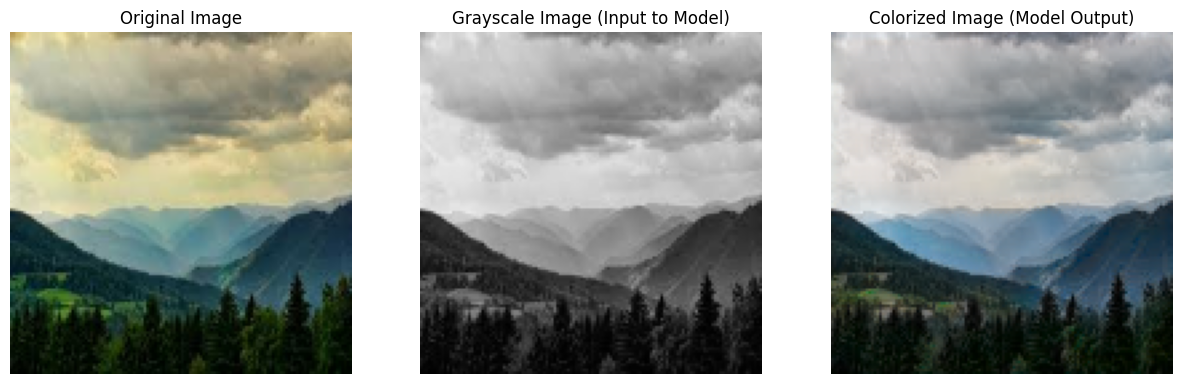

In [ ]:
# prompt: i did not the run above code now , so i have the checkpoint and best weights saved in google dirve , so i wiill input an image , convert it to black and white and then predict the colorized image using the saved model , print all 3

from PIL import Image
import matplotlib.pyplot as plt

# Load the saved weights
# Ensure the path points to the correct weights file you saved
best_weights_path = '/content/drive/MyDrive/colorization_checkpoints_20k/generator_best_psnr_scenery_lhq_20k.weights.h5'

# Check if the best weights file exists
if os.path.exists(best_weights_path):
    print(f"Loading best weights from: {best_weights_path}")
    # Load the generator model structure and then load weights
    generator = build_generator(input_shape=(IMG_SIZE, IMG_SIZE, 1)) # Assuming IMG_SIZE is defined in preceding code
    generator.load_weights(best_weights_path)
else:
    # If best weights not found, try loading from the last checkpoint
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        print(f"Best weights not found. Loading latest checkpoint: {latest}")
        ckpt.restore(latest).expect_partial()
        generator = ckpt.generator # Access the generator from the restored checkpoint
    else:
        print("Neither best weights nor latest checkpoint found. Cannot perform prediction.")
        # Exit or handle the error as appropriate
        exit()


# Function to preprocess and colorize an image
def colorize_image(image_path, generator, img_size=128):
    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]

    # Convert to LAB and get the L channel
    L_norm, ab_norm_true = rgb_to_lab_normalized(img) # Keep true ab for potential comparison
    L_norm_batch = tf.expand_dims(L_norm, axis=0) # Add batch dimension

    # Predict the ab channels using the generator
    pred_ab_norm = generator(L_norm_batch, training=False)

    # Convert back to RGB
    colorized_img_rgb = lab_to_rgb_normalized(L_norm_batch, pred_ab_norm)
    colorized_img_rgb = tf.squeeze(colorized_img_rgb, axis=0) # Remove batch dimension

    # Convert the original grayscale L channel back to grayscale RGB for display
    # A simple way is to stack the L channel three times and convert to RGB
    # Or, we can just convert the L channel (0-1 normalized) to 0-255 grayscale for display
    L_gray_display = tf.image.grayscale_to_rgb(L_norm) # Stack L for display as grayscale RGB

    # Convert to numpy arrays for display
    original_rgb_np = (img.numpy() * 255).astype('uint8')
    grayscale_rgb_np = (L_gray_display.numpy() * 255).astype('uint8')
    colorized_rgb_np = (colorized_img_rgb.numpy() * 255).astype('uint8')


    return original_rgb_np, grayscale_rgb_np, colorized_rgb_np

# --- Example Usage ---

# Provide the path to your input image in Google Drive or Colab runtime
# Example: input_image_path = '/content/drive/MyDrive/my_images/test_image.jpg'
input_image_path = '/content/seen2.jpeg'

# For demonstration, let's pick one image from the validation set paths if available
# if val_paths:
#     input_image_path = val_paths[0] # Use the first image from the validation set
#     print(f"Using example image from validation set: {input_image_path}")
# else:
#     # You might need to manually upload an image or specify a path here
#     print("No validation paths found. Please provide a valid image path.")
#     # Example manual path: input_image_path = '/content/my_uploaded_image.jpg'
#     # If no path is set, the script will not proceed to colorize
#     input_image_path = None # Set to None if no image path is available


if input_image_path and os.path.exists(input_image_path):
    # Get the three images
    original_img, grayscale_img, colorized_img = colorize_image(input_image_path, generator, img_size=IMG_SIZE)

    # Display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_img, cmap='gray') # Use cmap='gray' just in case, though it should be grayscale RGB
    plt.title('Grayscale Image (Input to Model)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(colorized_img)
    plt.title('Colorized Image (Model Output)')
    plt.axis('off')

    plt.show()
else:
    print(f"Input image path not found: {input_image_path}")


In [ ]:
import lpips
import torch
import numpy as np

# === Your images (already loaded as NumPy arrays) ===
# original_img, grayscale_img, colorized_img should be np.ndarray of shape (128, 128, 3), dtype=uint8

# Example:
# original_img = ...  # shape (128,128,3), dtype uint8
# colorized_img = ...  # shape (128,128,3), dtype uint8

def preprocess_for_lpips(img_np):
    # Convert from [0,255] uint8 -> [0,1] float32 -> [-1,1] torch tensor
    img_tensor = torch.tensor(img_np / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    img_tensor = img_tensor * 2 - 1
    return img_tensor

# Convert images
img1_tensor = preprocess_for_lpips(original_img)
img2_tensor = preprocess_for_lpips(colorized_img)

# Move to GPU if available
if torch.cuda.is_available():
    img1_tensor = img1_tensor.cuda()
    img2_tensor = img2_tensor.cuda()

# Load LPIPS model
loss_fn = lpips.LPIPS(net='alex')
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

# Compute LPIPS distance
lpips_score = loss_fn(img1_tensor, img2_tensor)
print(f"LPIPS score (Original vs. Colorized): {lpips_score.item():.4f}")


In [ ]:
import os
import random

# def get_image_paths_recursive(image_dir, exts=('.jpg','.jpeg','.png','.bmp','.tif')):
#     paths = []
#     for root, _, files in os.walk(image_dir):
#         for fname in files:
#             if fname.lower().endswith(exts):
#                 paths.append(os.path.join(root, fname))
#     return sorted(paths)

# Set these according to your setup  # Update with your path
n_total = 20000                  # Total images you have
n_train = 18000                  # Images used for training
n_val = 2000                     # Images used for validation

# all_paths = get_image_paths_recursive(image_dir)
selected_paths = all_paths[:n_total] if len(all_paths) >= n_total else all_paths

# Shuffle for randomness (optional, if not already shuffled)
random.shuffle(selected_paths)

# Split
train_paths = selected_paths[:n_train]
val_paths = selected_paths[n_train:n_train+n_val]
unused_paths = all_paths[n_total:]  # These are the "unused" images for LPIPS

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Unused: {len(unused_paths)}")


Train: 18000, Val: 2000, Unused: 70000


In [ ]:
import lpips
import torch
import tensorflow as tf
import numpy as np

# Initialize LPIPS metric
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lpips_metric = lpips.LPIPS(net='alex').to(device)  # 'alex', 'vgg', or 'squeeze'

def tf_to_torch(tf_tensor):
    """Convert TensorFlow tensor [H,W,3] in [0,1] to PyTorch tensor [1,3,H,W] in [-1,1]"""
    np_array = tf_tensor.numpy()
    np_array = np.transpose(np_array, (2, 0, 1))
    torch_tensor = torch.from_numpy(np_array).float().to(device)
    torch_tensor = torch_tensor * 2.0 - 1.0
    return torch_tensor.unsqueeze(0)

def calculate_lpips_score(original_rgb, colorized_rgb):
    """Calculate LPIPS score between original and colorized images"""
    with torch.no_grad():
        original_torch = tf_to_torch(original_rgb)
        colorized_torch = tf_to_torch(colorized_rgb)
        lpips_score = lpips_metric(original_torch, colorized_torch)
        return lpips_score.item()


In [ ]:
!pip install lpips

In [ ]:
import tensorflow_io as tfio

def load_and_preprocess_image(image_path, img_size=128):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def rgb_to_lab_normalized(rgb):
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)
    lab = tfio.experimental.color.rgb_to_lab(rgb)
    L = lab[..., :1] / 100.0
    ab = lab[..., 1:] / 127.0
    return L, ab

def lab_to_rgb_normalized(L, ab):
    L2 = L * 100.0
    ab2 = ab * 127.0
    lab = tf.concat([L2, ab2], axis=-1)
    rgb = tfio.experimental.color.lab_to_rgb(lab)
    return tf.clip_by_value(rgb, 0.0, 1.0)

# Evaluate on unused images
lpips_scores = []
num_samples = 1000  # Adjust as needed
sampled_paths = random.sample(unused_paths, min(num_samples, len(unused_paths)))

for image_path in sampled_paths:
    original_rgb = load_and_preprocess_image(image_path)
    L, _ = rgb_to_lab_normalized(original_rgb)
    L_batch = tf.expand_dims(L, axis=0)
    ab_pred = generator(L_batch, training=False)
    colorized_rgb = lab_to_rgb_normalized(L_batch, ab_pred)
    colorized_rgb = tf.squeeze(colorized_rgb, axis=0)
    score = calculate_lpips_score(original_rgb, colorized_rgb)
    lpips_scores.append(score)

print(f"Mean LPIPS score: {np.mean(lpips_scores):.4f}")


Mean LPIPS score: 0.1564
